# Part I - (Dataset Exploration Title)
## by Joel Hayhow

## Introduction

The dataset chosen is ProsperLoanData. It contains nearly 114000 loans borrowed plus variables associated with each. There are 81 variables given for each loan.

A full description of each variable can be found here: https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0

This description was provided by Udacity.

The dataset was also sourced from Udacity.


## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
dataset = pd.read_csv('prosperLoanData.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [4]:
dataset.shape

(113937, 81)

### What is the structure of your dataset?

The dataset contains 113,937 rows and 81 variables.

Most variables are floats or integers. Some variables, such as IncomeVerifiable, are booleans which may need to be encoded as 0 or 1.

Some columns are missing a lot of values, such as CreditRating.


#### Assessments

We need to find out what type of data the "object" columns contain: 

In [5]:
dataset.select_dtypes(include='bool')

,IsBorrowerHomeowner,CurrentlyInGroup,IncomeVerifiable
0,True,True,True
1,False,False,True
2,False,True,True
3,True,False,True
4,True,False,True
...,...,...,...
113932,True,False,True
113933,True,False,True
113934,True,False,True
113935,True,False,True


We can see there are three variables containing boolean values. Let's save the column names for later (if needed):

In [6]:
boolean_variables = dataset.select_dtypes(include='bool').columns
boolean_variables

Index(['IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable'], dtype='object')

Now checking the other columns containing objects. What type of object do they contain?

In [7]:
objects = dataset.select_dtypes(include='object')
objects.dtypes

ListingKey                 object
ListingCreationDate        object
CreditGrade                object
LoanStatus                 object
ClosedDate                 object
ProsperRating (Alpha)      object
BorrowerState              object
Occupation                 object
EmploymentStatus           object
GroupKey                   object
DateCreditPulled           object
FirstRecordedCreditLine    object
IncomeRange                object
LoanKey                    object
LoanOriginationDate        object
LoanOriginationQuarter     object
MemberKey                  object
dtype: object

There are quite a few present here! But can we find out which are timestamps, strings, etc.?

In [8]:
type(objects['Occupation'][0])

str

In [9]:
types = []
for col in objects.columns:
    type_object = type(objects[col][0])
    types.append(type_object)

In [10]:
types_columns = pd.DataFrame(types, objects.columns)

In [11]:
types_columns

,0
ListingKey,<class 'str'>
ListingCreationDate,<class 'str'>
CreditGrade,<class 'str'>
LoanStatus,<class 'str'>
ClosedDate,<class 'str'>
ProsperRating (Alpha),<class 'float'>
BorrowerState,<class 'str'>
Occupation,<class 'str'>
EmploymentStatus,<class 'str'>
GroupKey,<class 'float'>


So we can see that the vast majority of the object columns contain strings.

It turns out that GroupKey and ProsperRating (Alpha) are both floats. This will be important for any numerical analysis.

#### Assessments for cleaning
1. ListingCreationDate and ClosedDate are in string format not datetime format.
2. DateCreditPulled is in string format not datetime format.
3. Loan Origination Date is in string format not datetime format.
4. IncomeRange is a string not a float.

In [12]:
dataset.IncomeRange.value_counts()

$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64

#### Further assessments for cleaning
5. IncomeRange contains 7741 missing pieces of data.

Next the number of missing values in each column was found:

In [13]:
nans = dataset.isnull().sum()
nans[nans > 0]

CreditGrade                             84984
ClosedDate                              58848
BorrowerAPR                                25
EstimatedEffectiveYield                 29084
EstimatedLoss                           29084
EstimatedReturn                         29084
ProsperRating (numeric)                 29084
ProsperRating (Alpha)                   29084
ProsperScore                            29084
BorrowerState                            5515
Occupation                               3588
EmploymentStatus                         2255
EmploymentStatusDuration                 7625
GroupKey                               100596
CreditScoreRangeLower                     591
CreditScoreRangeUpper                     591
FirstRecordedCreditLine                   697
CurrentCreditLines                       7604
OpenCreditLines                          7604
TotalCreditLinespast7years                697
InquiriesLast6Months                      697
TotalInquiries                    

In [14]:
dataset.GroupKey

0                             NaN
1                             NaN
2         783C3371218786870A73D20
3                             NaN
4                             NaN
                   ...           
113932                        NaN
113933                        NaN
113934                        NaN
113935                        NaN
113936                        NaN
Name: GroupKey, Length: 113937, dtype: object

Many missing values! Selecting the columns which are missing more than half the values (these will be removed as contain too little data):

In [15]:
lotsofnans = nans[nans > 57000]
lotsofnans_names = lotsofnans.index
lotsofnans_names

Index(['CreditGrade', 'ClosedDate', 'GroupKey', 'TotalProsperLoans',
       'TotalProsperPaymentsBilled', 'OnTimeProsperPayments',
       'ProsperPaymentsLessThanOneMonthLate',
       'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed',
       'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing',
       'LoanFirstDefaultedCycleNumber'],
      dtype='object')

Having the list of columns with a high number of missing values will make it easier to drop these.

#### Further assessment

6. The columns in the list lotsofnans_names are more than half empty.

### Cleaning

#### Define:

1. The columns ListingCreationDate, ClosedDate, DateCreditPulled, Loan Origination Date should be converted to datetime format.

#### Code:

In [16]:
clean_datetimes = ['ListingCreationDate', 'ClosedDate', 'DateCreditPulled', 'LoanOriginationDate']
for column in clean_datetimes:
    dataset[column] = pd.to_datetime(dataset[column])

#### Test:

In [17]:
dataset[clean_datetimes].head()

,ListingCreationDate,ClosedDate,DateCreditPulled,LoanOriginationDate
0,2007-08-26 19:09:29.263,2009-08-14,2007-08-26 18:41:46.780,2007-09-12
1,2014-02-27 08:28:07.900,NaT,2014-02-27 08:28:14.000,2014-03-03
2,2007-01-05 15:00:47.090,2009-12-17,2007-01-02 14:09:10.060,2007-01-17
3,2012-10-22 11:02:35.010,NaT,2012-10-22 11:02:32.000,2012-11-01
4,2013-09-14 18:38:39.097,NaT,2013-09-14 18:38:44.000,2013-09-20


In [18]:
dataset[clean_datetimes].dtypes

ListingCreationDate    datetime64[ns]
ClosedDate             datetime64[ns]
DateCreditPulled       datetime64[ns]
LoanOriginationDate    datetime64[ns]
dtype: object

Successfully converted to datetime format. This will make numerical analysis easier later on.

#### Define:

2. The columns more than half empty should be dropped from the dataset.

#### Code:

In [19]:
dataset = dataset.drop(columns = lotsofnans_names)

#### Test:

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 69 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingKey                          113937 non-null  object        
 1   ListingNumber                       113937 non-null  int64         
 2   ListingCreationDate                 113937 non-null  datetime64[ns]
 3   Term                                113937 non-null  int64         
 4   LoanStatus                          113937 non-null  object        
 5   BorrowerAPR                         113912 non-null  float64       
 6   BorrowerRate                        113937 non-null  float64       
 7   LenderYield                         113937 non-null  float64       
 8   EstimatedEffectiveYield             84853 non-null   float64       
 9   EstimatedLoss                       84853 non-null   float64       
 10  Estimate

Now we have mostly full columns in the dataset, with mostly numeric variables.

#### Some initial exploration of numeric variables

In [21]:
dataset.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6.005540e+05,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,8.926340e+05,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,1.255725e+06,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


Some initial observations, from the above table:

1. The mean length of a loan term is 41 months to the nearest month. 
2. The Lender Yield appears to be on average about 1% lower than the interest rate (BorrowerRate), so we can deduce that the service fee is on avergae around 1% of the loan value.
3. The mean estimated effective yield is lower than the lender yield. These may be correlated but there could be hidden costs and we do not know the distribution for these hidden costs.
4. The loan rating (ProsperRating (numeric)) is on a scale of 1.0 to 7.0 and has a mean around 4.07. It will be interesting to see if this is normally distributed.
5. Investors contribute much more to a fund than friends. On average, for each friend contributing to a fund, there are about 80.48/0.0235 = approximately 3430 investors for every financially invested friend. This means we can likely ignore the effects of nepotism as a source of bias. However this does not mean other sources of bias are eliminated.

These observations suggest that the estimated effective yield, the Prosper Rating (numeric) (the rating given to each loan by Prosper), and the service fees are all interesting indicators to examine.

In addition, the credit scores may be of interest since they reflect the reliability of the borrower. 

These are just initial thoughts.

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in finding what features best predict loan yield.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

After an initial examination the following variables may be good predictors of loan yield:

1. EstimatedEffectiveYield
2. ProsperRating (numeric)
3. LP_ServiceFees
4. CreditScoreRangeLower
5. CreditScoreRangeUpper

The next part looks into each of these variables.

## Univariate Exploration


#### LenderYield

As this is the variable to predict it is the best variable to begin examining.

**Question: What is the distribution of LenderYield?**

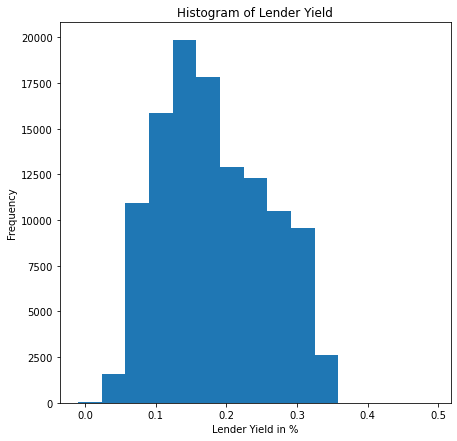

In [22]:
dataset['LenderYield'].plot(kind='hist',title='Histogram of Lender Yield',ylabel='Frequency Density',figsize=(7,7), bins=15)
plt.xlabel('Lender Yield in %')
plt.show()

*Observations:*

1. This does not appear to follow a normal distribution but is skewed slightly left. Also, the lender yield varies by only a fraction of a percent. Most yield seems to congregate around 0.15%.

2. There seem to be some strange values below 0.05% which may need to be removed. This is examined next.

In [23]:
dataset.LenderYield[dataset.LenderYield < 0.0]

29859    -0.0050
46874    -0.0100
50251    -0.0099
53423    -0.0095
53558    -0.0029
65259    -0.0100
76858    -0.0100
77776    -0.0050
78401    -0.0050
78920    -0.0100
90051    -0.0050
112717   -0.0100
Name: LenderYield, dtype: float64

So there are very few values where the lender actually lost money. These may not actually be outliers but are simply loans which did not work out well for the lender.

Looking for outliers at the top of the distribution:

In [24]:
dataset.LenderYield[dataset.LenderYield > 0.4]

18326     0.4325
22195     0.4325
36018     0.4925
56761     0.4800
82043     0.4750
103973    0.4325
Name: LenderYield, dtype: float64

We can check if these "outliers" make much difference by plotting the distribution again without them:

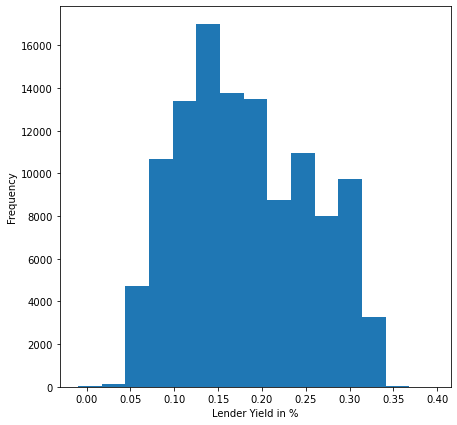

In [25]:
dataset.LenderYield[dataset.LenderYield < 0.4].plot(kind='hist', ylabel='Frequency Density',bins=15,figsize=(7,7))
plt.xlabel('Lender Yield in %')
plt.show()

*Observations*:

1. Interestingly, there are now some ups and downs in the data which were not visible before, which suggests the LenderYield is not distributed unimodally.

2. Nevertheless the distribution is still skewed left. 

To look at these peaks in more detail we can increase the number of bins:

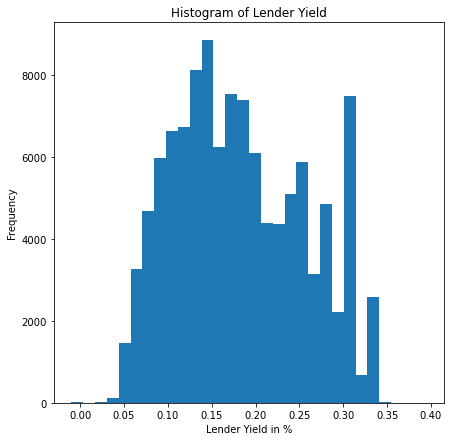

In [26]:
dataset.LenderYield[dataset.LenderYield < 0.4].plot(kind='hist', title = 'Histogram of Lender Yield', ylabel='Frequency Density',bins=30,figsize=(7,7))
plt.xlabel('Lender Yield in %')
plt.show()

Around the lender yield of 0.15%, there is a clear peak, as was observed at first. However, there is also a clear peak - with a very high number of loans! - around 0.30%. We can increase the resolution and plot both a histogram and a kernel distribution function to observe whether this distribution is really more than unimodal.

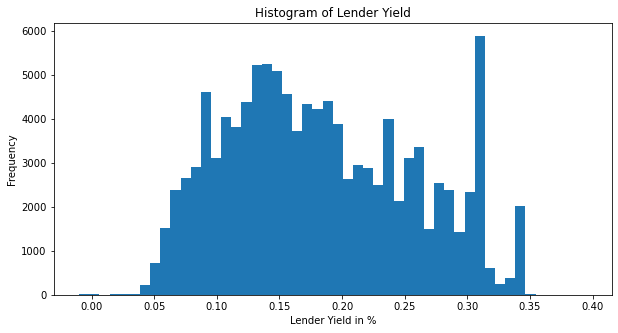

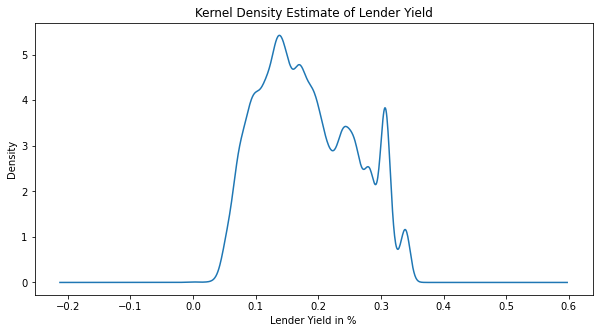

In [27]:
dataset.LenderYield[dataset.LenderYield < 0.4].plot(kind='hist', ylabel='Frequency Density',bins=50,figsize=(10,5),title='Histogram of Lender Yield')
plt.xlabel('Lender Yield in %')
plt.show()
dataset.LenderYield[dataset.LenderYield < 0.4].plot(kind='kde', ylabel='Frequency Density', figsize=(10,5), title='Kernel Density Estimate of Lender Yield')
plt.xlabel('Lender Yield in %')

plt.show()

*Observations*:

1. Histogram: we see that the distribution is very likely bimodal. It has peaks around 0.15% and 0.30%. Interestingly, the histogram shows the highest number of loans per bin is around the 0.31% mark. Instead of decreasing smoothly after this peak, the distribution falls away very sharply before rising again.

2. Kernel Density Estimate: the peaks are also present at around the same points. However the second peak, around 0.30% lender yield, is shown as lower than the maximum around 0.15%. 

3. These plots show two possible interpretations of the second peak. In the KDE plot, which relies on contributions from **all** datapoints, the second peak is shorter. In the histogram, which only considers the contribution from within a given bin, this is not the case. It is not clear which plot should be favoured especially as these are only univariate plots.

However the *most important observation* is that the LenderYield distribution does appear to be bimodal.

Now we move on to the predictors.

### Univariate Distributions of the Features

The first feature of interest is the estimated effective yield.

Text(0.5, 0, '% Effective Yield')

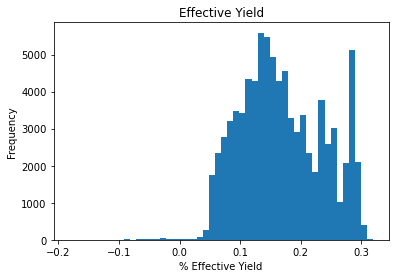

In [28]:
# Looking at the estimated effective yield:

dataset.EstimatedEffectiveYield.plot(kind='hist', bins=50,title='Effective Yield')
plt.xlabel('% Effective Yield')

This looks very similar to the Lender Yield. Let's calculate a correlation between the two variables:

In [29]:
correlation = np.corrcoef(dataset['LenderYield'], dataset['EstimatedEffectiveYield'])

In [30]:
correlation[0][0]

0.9999999999999998

They follow each other almost perfectly, so let's compare other statistics:

In [31]:
dataset[['EstimatedEffectiveYield', 'LenderYield']].describe()

,EstimatedEffectiveYield,LenderYield
count,84853.000000,113937.000000
mean,0.168661,0.182701
std,0.068467,0.074516
min,-0.182700,-0.010000
25%,0.115670,0.124200
50%,0.161500,0.173000
75%,0.224300,0.240000
max,0.319900,0.492500


*Observations:*

1. Although the correlation is extremely high, the effective yield is generally lower than the lender yield. 

2. This confirms the reliability of these two columns of data. In the description of the variables provided at the top of this report, effective yield is simply lender yield minus estimated uncollected interest, minus estimated late service fees. We therefore expect it to follow the same distribution but with a smaller magnitude. 

3. Although this shows the data has been reliably calculated for these two columns, it also means that one is not a useful predictor of the other, since one is needed to calculate the other.

______________________________________________________________________________________________________________________________


Next to be investigated is the Prosper Rating of each loan (numeric data only).

In [32]:
prosperrating = dataset['ProsperRating (numeric)']
prosperrating.head()

0    NaN
1    6.0
2    NaN
3    6.0
4    3.0
Name: ProsperRating (numeric), dtype: float64

In [33]:
prosperrating.unique()

array([nan,  6.,  3.,  5.,  2.,  4.,  7.,  1.])

In [34]:
prosperrating.value_counts().sort_index(ascending=True)

1.0     6935
2.0     9795
3.0    14274
4.0    18345
5.0    15581
6.0    14551
7.0     5372
Name: ProsperRating (numeric), dtype: int64

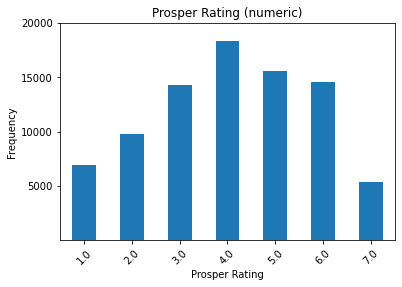

In [35]:
prosperrating.value_counts().sort_index(ascending=True).plot.bar(title = 'Prosper Rating (numeric)', yticks=[5000, 10000, 15000,20000], rot=45)
plt.xlabel('Prosper Rating')
plt.ylabel('Frequency')
plt.show()

Prosper Rating is a rating given to a loan to indicate its estimated risk. 

It ranges from 1 (= High Risk) to 7 (an AA rating). Most loans fall in the medium risk category.

*Observations*: 

> It is apparently unimodal, which means it will likely not correlate well with the Lender Yield, which we saw was bimodal.


____________________________________________________________________________________________________________________________

Next are the credit scores. We can see what credit scores are present using the value_counts() function:

In [36]:
dataset[['CreditScoreRangeUpper', 'CreditScoreRangeLower']].value_counts()

CreditScoreRangeUpper  CreditScoreRangeLower
699.0                  680.0                    16492
679.0                  660.0                    16366
719.0                  700.0                    15471
739.0                  720.0                    12923
659.0                  640.0                    12199
759.0                  740.0                     9267
779.0                  760.0                     6606
799.0                  780.0                     4624
639.0                  620.0                     4172
619.0                  600.0                     3602
819.0                  800.0                     2644
539.0                  520.0                     1593
559.0                  540.0                     1474
839.0                  820.0                     1409
579.0                  560.0                     1357
599.0                  580.0                     1125
859.0                  840.0                      567
519.0                  500.0         

Clearly, credit score is a discrete variable. It rises in increments of 20. Plotting as a bar chart:

<AxesSubplot:title={'center':'Credit Scores (Upper Bound)'}, xlabel='Credit Score', ylabel='Frequency'>

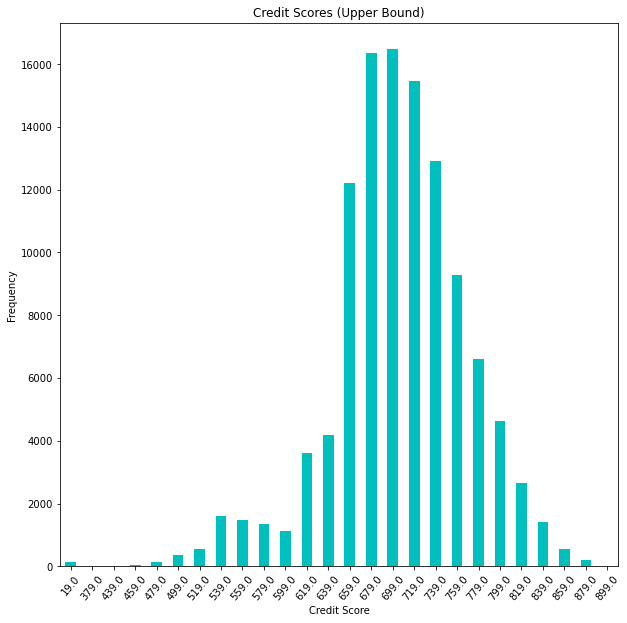

In [37]:
dataset['CreditScoreRangeUpper'].value_counts().sort_index(ascending=True).plot.bar(color = 'c', title='Credit Scores (Upper Bound)', xlabel='Credit Score', ylabel='Frequency', rot=50, figsize=(10,10))

The Credit Score axis rises consistently in increments of 20, apart from the region Credit Score < 439.0. It is reasonable to assume any values in this region are outliers as there is a huge gap between the values of 19.0 and any values above.

Removing these and replotting:

In [38]:
credits = dataset['CreditScoreRangeUpper']

<AxesSubplot:title={'center':'Credit Scores (Upper Bound)'}, xlabel='Credit Score', ylabel='Frequency'>

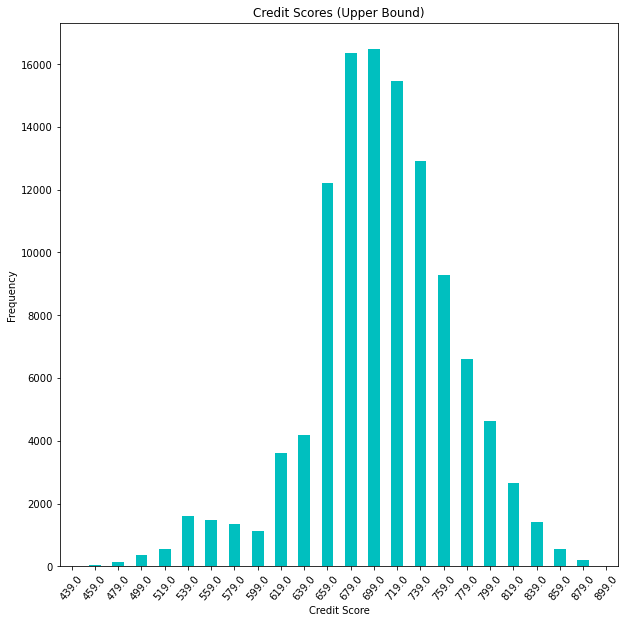

In [39]:
credits.where(credits >= 439.0).value_counts().sort_index(ascending=True).plot.bar(color = 'c', title='Credit Scores (Upper Bound)', xlabel='Credit Score', ylabel='Frequency', rot=50, figsize=(10,10))

The distribution is slightly skewed right. There is some interesting fluctuation for credit scores between 539.0 and 639.0. The graph falls away smoothly on the right-hand side. It appears to be roughly unimodal and therefore will not correlate well with lender yield.

So far we have looked at the upper bound credit scores. We can now visualize both upper bounds and lower bounds:

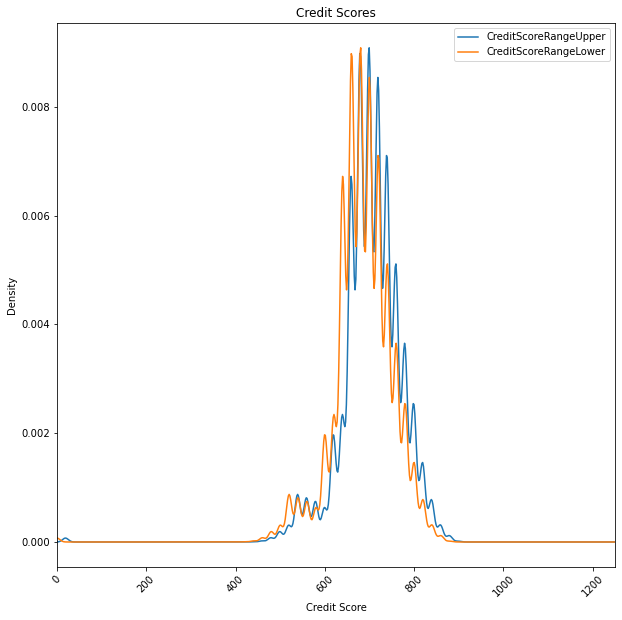

In [40]:
# Investigating the credit scores and how these are distributed
dataset[['CreditScoreRangeUpper', 'CreditScoreRangeLower']].plot(kind='kde', title='Credit Scores', figsize=(10,10), rot = 45)
plt.xlabel('Credit Score')
plt.xlim(0,1250)
plt.show()

*Observations:*

1. By eye, we can see (again) that there may be some outliers around 0. There are no apparent values above a credit score of 1000.
2. The minimum credit score just lags behind the upper credit score. This is what is expected as the minimum credit score and the maximum credit score are the lower and upper bounds of a borrower's credit score. According to the documentation, this is calculated by an external agency.
3. Under the kernel density estimate, the credit score appears to be approximately following a normal distribution. Since the distribution shown by the bar chart was not normal, it may be that the KDE is biased in favour of normal distributions in this case, as it fits a standard function to the graph rather than displaying raw data.

### Finding unreliable values:

Next we can double-check there are no unreliable values. by comparing the upper and lower bounds. Unreliable scores (should there be any) will not differ by the expected amount.

Calculating the range of a given borrower's score, and depicting this:

Text(0.5, 0, 'Index of Borrower')

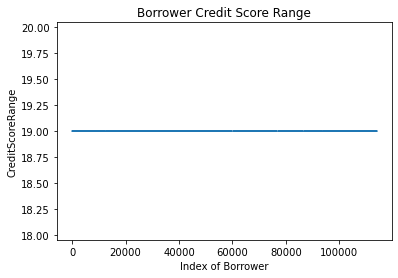

In [41]:
# Calculating the range of a borrower's score:

range_scores = dataset['CreditScoreRangeUpper'] - dataset['CreditScoreRangeLower']
range_scores.plot(kind='line', title='Borrower Credit Score Range',ylabel='CreditScoreRange')
plt.xlabel('Index of Borrower')

There appear to be no variations from the graph. So these two scores are more likely to be reliably computed.

But we can check more thoroughly. The required range appears to be 19.00. We can check if any ranges are *not* 19.00:

In [42]:
# There appear to be 591 'nan' values. Let's check if there are any values which are neither 19.00 or a nan value:
range_scores[range_scores != 19.00].isnull().sum()

591

In [43]:
invalid_ranges = range_scores[range_scores != 19.00].index
invalid_ranges

Int64Index([   206,    387,    698,   1023,   1126,   1148,   1844,   1907,
              1932,   2029,
            ...
            111607, 111853, 112198, 112387, 112561, 112680, 113015, 113438,
            113902, 113921],
           dtype='int64', length=591)

This shows the range has been properly calculated where both credit scores were provided. The rows returning 'Nan', however, should be dropped:

In [44]:
invalid_ranges = range_scores[range_scores != 19.00].index
credit_scores = dataset[['CreditScoreRangeLower', 'CreditScoreRangeUpper']]
credit_scores = credit_scores.drop(index = invalid_ranges)

Check:

In [45]:
credit_scores

,CreditScoreRangeLower,CreditScoreRangeUpper
0,640.0,659.0
1,680.0,699.0
2,480.0,499.0
3,800.0,819.0
4,680.0,699.0
...,...,...
113932,700.0,719.0
113933,700.0,719.0
113934,700.0,719.0
113935,680.0,699.0


We have seen that:

> The upper and lower bounds follow each other closely and have the same distribution.

> The data is best visualized using a bar chart rather than a KDE

> There were NaNs which had to be dropped.

> Credit scores below 439.0 are likely outliers and should be dropped.

So the final visualization of this variable is:

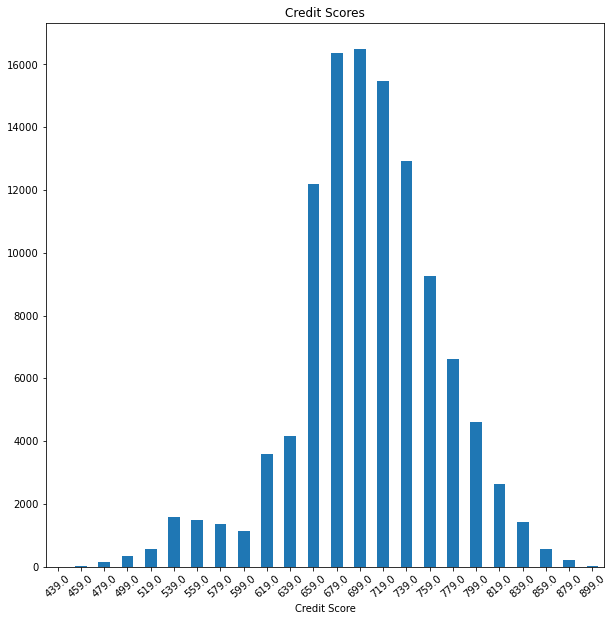

In [46]:
# Replotting the credit scores after the cleaning exercise, using a bar chart (as KDE may bias the distribution):

credit_scores['CreditScoreRangeUpper'].where(credit_scores['CreditScoreRangeUpper'] >= 439.0).value_counts().sort_index(ascending=True).plot(kind='bar', rot = 40, figsize=(10,10), title='Credit Scores')
plt.xlabel('Credit Score')
plt.show()

*Observation*: The credit score rating is clearly unimodal, but not normally distributed.

___________________________________________________________________________________________________________________________
Next to investigate are the *fees paid by investors*. **What is their distribution?**

These are in two categories of numeric data:

1. LP_ServiceFee, the service fees paid by investors.
2. LP_CollectionFee, the collection fees paid by investors.

Later, we can see how these fees relate to loan yield. (And therefore, whether investors can expect to get their money's worth). 

But first we should investigate the data these columns contain.

In [47]:
investor_fees = dataset[['LP_ServiceFees', 'LP_CollectionFees']]
investor_fees.describe()

,LP_ServiceFees,LP_CollectionFees
count,113937.000000,113937.000000
mean,-54.725641,-14.242698
std,60.675425,109.232758
min,-664.870000,-9274.750000
25%,-73.180000,0.000000
50%,-34.440000,0.000000
75%,-13.920000,0.000000
max,32.060000,0.000000


*Observations:*

1. The fees are negative. They show deductions.
2. The collection fees are more widely spread out than the service fees.
3. The service fees are on average greater than the collection fees, from the investor's point of view.
4. The LP Collection Fees column shows "0.0000" for the quartiles and the maximum value. This suggests cleaning to be done.

In [48]:
# Cleaning the collection fees before examining their distribution

dataset.LP_CollectionFees.value_counts()

 0.0000       105771
-17.0000          55
-8.5000           54
-29.5300          45
-34.0000          43
               ...  
-94.0700           1
-1011.6700         1
-63.8300           1
-18.1500           1
-105.6394          1
Name: LP_CollectionFees, Length: 6175, dtype: int64

There is an interesting observation here. 

The vast majority of the collection fees have value 0. This shows that investors, most of the time, do not have to pay loan collection.

The main charge is therefore the service fee. The interesting feature is thereforethe total fee paid by investors, rather than the type of fee. 

Let's create a new feature called total_fee_investors:

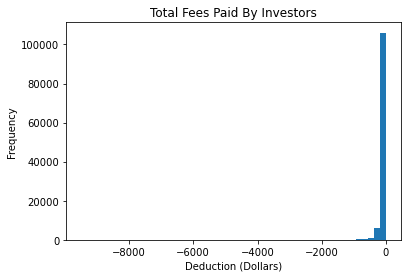

In [49]:
total_fee_investors = dataset.LP_CollectionFees + dataset.LP_ServiceFees
total_fee_investors.plot(kind='hist', bins = 50, title='Total Fees Paid By Investors')
plt.xlabel('Deduction (Dollars)')
plt.show()

This strongly suggests outliers. Let us find lower outliers:

In [50]:
total_fee_investors[total_fee_investors < -2000]

983      -2476.99
2279     -3047.31
7536     -5681.05
8811     -2702.44
9828     -2449.31
           ...   
108238   -2852.37
108249   -2099.75
109247   -2137.27
110082   -2166.22
112949   -3039.61
Length: 61, dtype: float64

Removing these 61 values and replotting the histogram:

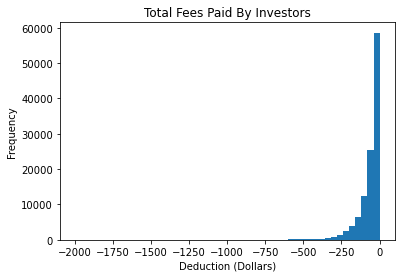

In [51]:
total_fee_investors[total_fee_investors > -2000].plot(kind='hist', bins = 50, title='Total Fees Paid By Investors')
plt.xlabel('Deduction (Dollars)')
plt.show()

The distribution remains the same shape. In fact, plotting the 61 values previously removed also gives the same shape:

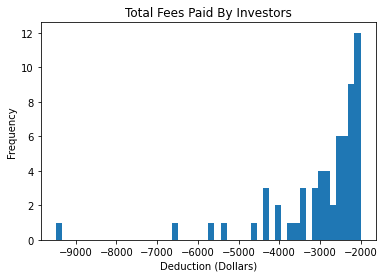

In [52]:
total_fee_investors[total_fee_investors < -2000].plot(kind='hist', bins = 50, title='Total Fees Paid By Investors')
plt.xlabel('Deduction (Dollars)')
plt.show()

The fact that these "outliers" follow a similar pattern may mean they are not actually outliers.

Instead, then, I will plot all the investor fees on a log-scale, to account for the range of y-values:

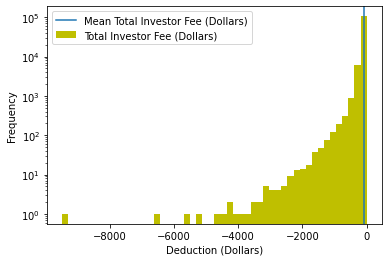

In [53]:
total_fee_investors.plot.hist(bins=50, color='y', label='Total Investor Fee (Dollars)')
plt.yscale('log')
plt.xlabel('Deduction (Dollars)')
plt.axvline(x = total_fee_investors.mean(),label='Mean Total Investor Fee (Dollars)')
plt.legend()
plt.show()

The resulting (smoother) distribution is very positively skewed.

*Observations*

1. The vast majority of investor fees are in the region 0-1000 dollars.
2. They fall away very steeply as the deduction increases.
3. Mean is clearly not a good indicator of investor fee.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

1. Credit score and Prosper Rating appear to be normally distributed.
2. Both measures of yield appear to be bimodal and skewed left.
3. Both measures of yield fall away very quickly after a yield of 0.31%. Then the yields rise very sharply until a yield of about 0.35%. The region 0.31% - 0.35% is interesting - why do the high-yield loans lie mostly outside this range?
4. Interestingly, the investor fees do not follow the same distribution as the loan rating.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

*Summary Observations*:

1. Both credit score and Prosper Rating appear to be normally distributed. This means investigating the relationship between them should be a point of attention.
2. Lender Yield appeared to be unimodal, until upper outliers were removed, in which case it appeared to be bimodal!
3. The data columns investigated appear to be reliable. This could be seen because effective yield is calculated from lender yield, and also the credit upper and lower scores are calculated from each other. The plots follow each other very closely.
4. The credit scores are provided as upper and lower bounds. Where both the upper and lower bounds were not provided, the rows were dropped. 

Now for the bivariate distributions.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

The variables to be explored are:

1. Credit Scores.
2. Prosper Rating (numeric).

They are going to be explored in relation to the effective yield of a loan.

Hence the question is:

**How do credit score and Prosper Rating relate to effective yield?**

*N.B.* Because the credit scores missing only contained NaN values, the original dataset column is being used so that a new dataframe can be created and a pairgrid plot obtained.

In [54]:
# Creating a scatter matrix of these variables to see any initial correlations:

effectiveyield = dataset['EstimatedEffectiveYield']
credit = credit_scores['CreditScoreRangeUpper'].where(credit_scores['CreditScoreRangeUpper'] >= 439.0)
ProsperRating = dataset['ProsperRating (numeric)']

array([[<AxesSubplot:xlabel='EstimatedEffectiveYield', ylabel='EstimatedEffectiveYield'>,
        <AxesSubplot:xlabel='CreditScoreRangeUpper', ylabel='EstimatedEffectiveYield'>,
        <AxesSubplot:xlabel='ProsperRating (numeric)', ylabel='EstimatedEffectiveYield'>],
       [<AxesSubplot:xlabel='EstimatedEffectiveYield', ylabel='CreditScoreRangeUpper'>,
        <AxesSubplot:xlabel='CreditScoreRangeUpper', ylabel='CreditScoreRangeUpper'>,
        <AxesSubplot:xlabel='ProsperRating (numeric)', ylabel='CreditScoreRangeUpper'>],
       [<AxesSubplot:xlabel='EstimatedEffectiveYield', ylabel='ProsperRating (numeric)'>,
        <AxesSubplot:xlabel='CreditScoreRangeUpper', ylabel='ProsperRating (numeric)'>,
        <AxesSubplot:xlabel='ProsperRating (numeric)', ylabel='ProsperRating (numeric)'>]],
      dtype=object)

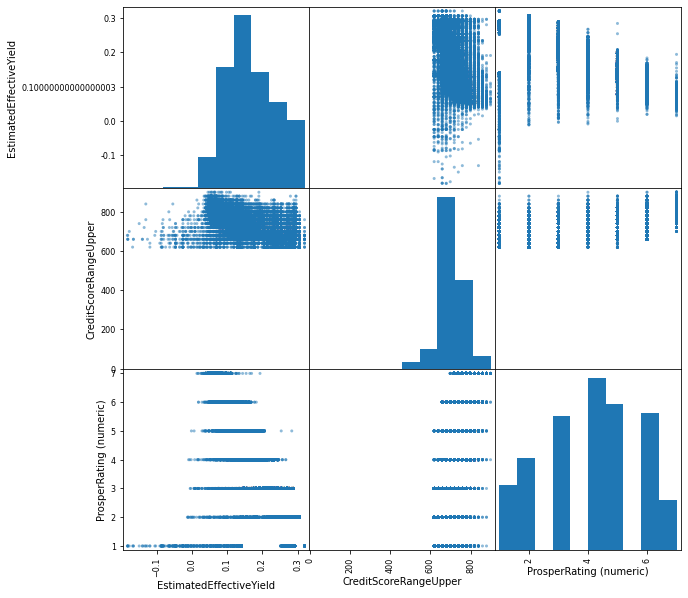

In [55]:
variables = dataset[['EstimatedEffectiveYield', 'CreditScoreRangeUpper', 'ProsperRating (numeric)']]

from pandas.plotting import scatter_matrix

scatter_matrix(variables, figsize = (10,10))

*Observations:*

1. There appear to be no meaningful relationships between most of these variables. Particularly surprising is that Prosper Rating and Credit Score possess basically zero correlation.

2. One interesting shape is the graph of estimated effective yield against Prosper Rating. As the Prosper Rating increases, the spread of the effective yield decreases. This suggests that the lower Prosper Ratings are very high risk, as the effective yield could be very high (~ 0.3%) or very low (~-0.1%). On the other hand, higher Prosper Ratings range from around 0.0% to 0.2% effective yield. While they are not as potentially high-return, they are more secure as their return is always positive.

__________________________________________________________________________________________________________________________

However, the second observation from the scattermatrix is very interesting.

We could separate the effective yield into subgroups, each corresponding to the relevant ProsperRating. Then the standard deviation of each subgroup could be plotted against Prosper Rating. 

And so our question is:

**How does the risk associated with a loan relate to its Prosper Rating?**

In [56]:
prosper_yield = dataset[['EstimatedEffectiveYield', 'ProsperRating (numeric)']]
prosper_yield.head()

,EstimatedEffectiveYield,ProsperRating (numeric)
0,NaN,NaN
1,0.07960,6.0
2,NaN,NaN
3,0.08490,6.0
4,0.18316,3.0


In [57]:
prosper_yield.dropna()

,EstimatedEffectiveYield,ProsperRating (numeric)
1,0.07960,6.0
3,0.08490,6.0
4,0.18316,3.0
5,0.11567,5.0
6,0.23820,2.0
...,...,...
113932,0.16490,4.0
113933,0.10070,6.0
113934,0.18828,3.0
113935,0.24450,4.0


In [58]:
group1 = prosper_yield[prosper_yield['ProsperRating (numeric)'] == 6.0]
group1.head()

,EstimatedEffectiveYield,ProsperRating (numeric)
1,0.0796,6.0
3,0.0849,6.0
13,0.0905,6.0
14,0.0827,6.0
18,0.0849,6.0


In [59]:
group2 = prosper_yield[prosper_yield['ProsperRating (numeric)'] == 5.0]
group3 = prosper_yield[prosper_yield['ProsperRating (numeric)'] == 4.0]
group4 = prosper_yield[prosper_yield['ProsperRating (numeric)'] == 3.0]
group5 = prosper_yield[prosper_yield['ProsperRating (numeric)'] == 2.0]
group6 = prosper_yield[prosper_yield['ProsperRating (numeric)'] == 1.0]

In [60]:
# Now calculating the standard deviation of the effective yield in each group:
groups = [group1, group2, group3, group4, group5, group6]
standard_dev = []
for group in groups:
    std = sd1 = np.std(group.EstimatedEffectiveYield.values)
    standard_dev.append(std)
    
# Note the standard deviations are in the order of decreasing Prosper Rating!
Prosper_Ratings = [6.0,5.0,4.0,3.0,2.0,1.0]

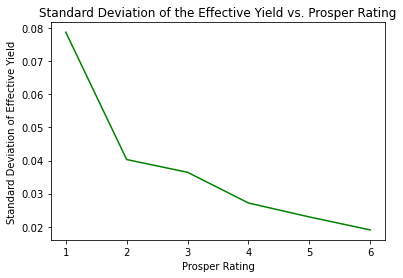

In [61]:
plt.plot(Prosper_Ratings, standard_dev, color='g')
plt.title('Standard Deviation of the Effective Yield vs. Prosper Rating')
plt.xlabel('Prosper Rating')
plt.ylabel('Standard Deviation of Effective Yield')
plt.show()

*Observations:*
1. There is a clear decreasing trend. As the prosper rating increases (as the loan decreases in risk) the effective yield's standard deviation decreases. Hence the effective yield is much more predictable for high Prosper Ratings, and lower in risk.

2. This shows that Prosper Rating is likely a good indicator of risk.

__________________________________________________________________________________________________________________________

**How does borrower credit score relate to effective yield?**

The final part of the bivariate analysis looks at borrower credit score and effective yield of a given loan.

Earlier, it seemed there was no correlation between risk assessment (Prosper Rating) and credit score. Now we will compare effective yield and credit score directly.

In [62]:
# Creating a dataframe of effective yield and credit scores (upper bounds only)
yield_credit = dataset[['EstimatedEffectiveYield', 'CreditScoreRangeUpper']]
yield_credit.head()

,EstimatedEffectiveYield,CreditScoreRangeUpper
0,NaN,659.0
1,0.07960,699.0
2,NaN,499.0
3,0.08490,819.0
4,0.18316,699.0


In [63]:
# Drop the NaN values
yield_credit.dropna()

,EstimatedEffectiveYield,CreditScoreRangeUpper
1,0.07960,699.0
3,0.08490,819.0
4,0.18316,699.0
5,0.11567,759.0
6,0.23820,699.0
...,...,...
113932,0.16490,719.0
113933,0.10070,719.0
113934,0.18828,719.0
113935,0.24450,699.0


In [64]:
yield_credit.head()

,EstimatedEffectiveYield,CreditScoreRangeUpper
0,NaN,659.0
1,0.07960,699.0
2,NaN,499.0
3,0.08490,819.0
4,0.18316,699.0


Since we are comparing a discrete variable with a continuous variable, a box plot is appropriate:

In [65]:
yield_credit.groupby(['CreditScoreRangeUpper']).head()

,EstimatedEffectiveYield,CreditScoreRangeUpper
0,NaN,659.0
1,0.07960,699.0
2,NaN,499.0
3,0.08490,819.0
4,0.18316,699.0
...,...,...
33122,NaN,459.0
36448,NaN,439.0
51093,NaN,439.0
60011,NaN,439.0


In [66]:
yield_credit[yield_credit['CreditScoreRangeUpper'] >= 439.0]

,EstimatedEffectiveYield,CreditScoreRangeUpper
0,NaN,659.0
1,0.07960,699.0
2,NaN,499.0
3,0.08490,819.0
4,0.18316,699.0
...,...,...
113932,0.16490,719.0
113933,0.10070,719.0
113934,0.18828,719.0
113935,0.24450,699.0


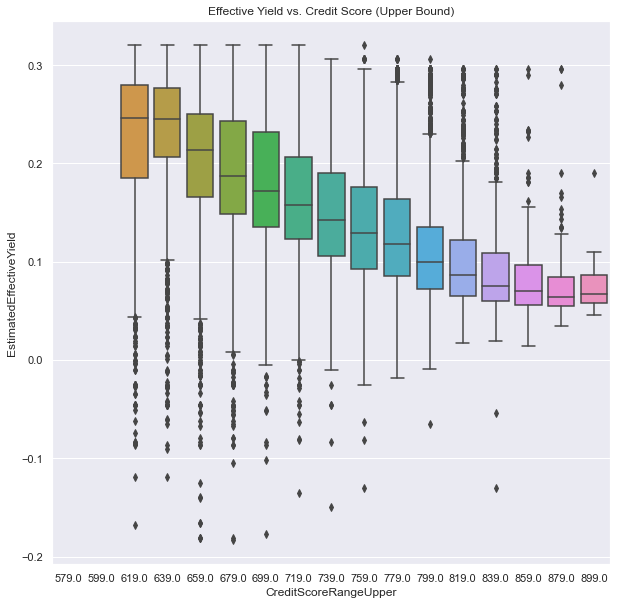

In [67]:
import seaborn as sns
sns.set(rc={"figure.figsize":(10, 10)})
ax = sns.boxplot(x = 'CreditScoreRangeUpper', y='EstimatedEffectiveYield', data = yield_credit[yield_credit['CreditScoreRangeUpper'] >= 579.0])
plt.title('Effective Yield vs. Credit Score (Upper Bound)')
plt.show()

*Observations:*
1. There appears to be a moderate negative correlation between mean effective yield and credit score.
2. The length of the box plots decreases as credit score increases. This may be similar to the previous relationship investigated. As credit score increases, the spread of the effective yield decreases. We can do a similar analysis to that in the previous section to see this more clearly.


**Does the standard deviation of the effective yield also decrease with increasing credit score?**

In [68]:
# Finding what credit scores are present in the data:
yield_credit['CreditScoreRangeUpper'].value_counts()

699.0    16492
679.0    16366
719.0    15471
739.0    12923
659.0    12199
759.0     9267
779.0     6606
799.0     4624
639.0     4172
619.0     3602
819.0     2644
539.0     1593
559.0     1474
839.0     1409
579.0     1357
599.0     1125
859.0      567
519.0      554
499.0      346
879.0      212
479.0      141
19.0       133
459.0       36
899.0       27
439.0        5
379.0        1
Name: CreditScoreRangeUpper, dtype: int64

There are set credit scores. We can choose to calculate np.std() of the effective yield for each credit score.

In [69]:
# Drop the NaN values!
yield_credit = yield_credit.dropna()
yield_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84853 entries, 1 to 113936
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EstimatedEffectiveYield  84853 non-null  float64
 1   CreditScoreRangeUpper    84853 non-null  float64
dtypes: float64(2)
memory usage: 1.9 MB


In [70]:
yc = yield_credit.groupby(['CreditScoreRangeUpper'])['EstimatedEffectiveYield'].std()
yc.head()

CreditScoreRangeUpper
619.0    0.081540
639.0    0.069017
659.0    0.058137
679.0    0.059493
699.0    0.061833
Name: EstimatedEffectiveYield, dtype: float64

In [71]:
#Sorting the unique credit score values from smallest to greatest:
credit_values = sorted(yield_credit.CreditScoreRangeUpper.unique())

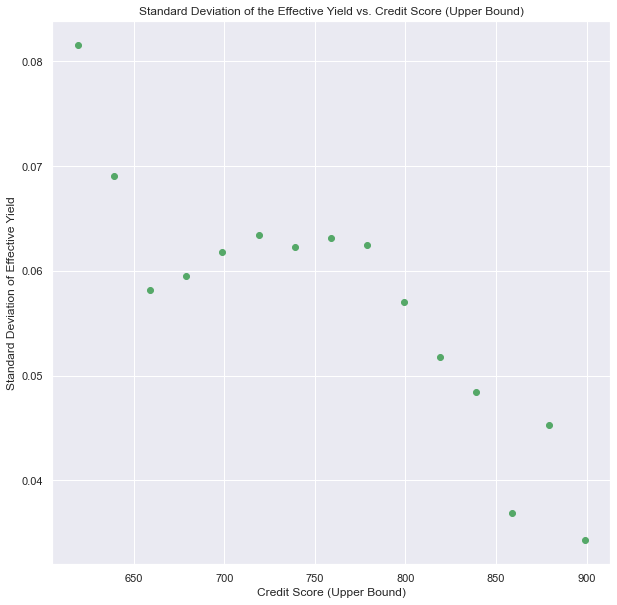

In [72]:
plt.scatter(credit_values, yc.values, color='g',)
plt.title('Standard Deviation of the Effective Yield vs. Credit Score (Upper Bound)')
plt.xlabel('Credit Score (Upper Bound)')
plt.ylabel('Standard Deviation of Effective Yield')
plt.show()

*Observations*:

1. Overall, the standard deviation does decrease.
2. The relationship is not straightforward. For credit scores in the region 650-700, the standard deviation dips sharply.
3. For the range 700-780, the credit score has little effect on the spread of the effective yield.
4. For a very high credit score of around 880, the effective yield suddenly spreads out. This is also out of line with the rest of the data.

Therefore, although the overall trend is that the spread decreases with increasing credit score - indicating increased reliability overall - the trend is not straightforward. It could be that Prosper Rating is a better indicator, therefore, of risk, than the borrower's credit score.

This is what we would expect given that borrower's credit score is only one indicator, whereas Prosper Rating takes into account many other factors (which we have not discussed in this analysis).

______________________________________________________________________________________________________________________________

Finally we will look at whether the total fee paid by investors has a noticeable impact on effective yield:

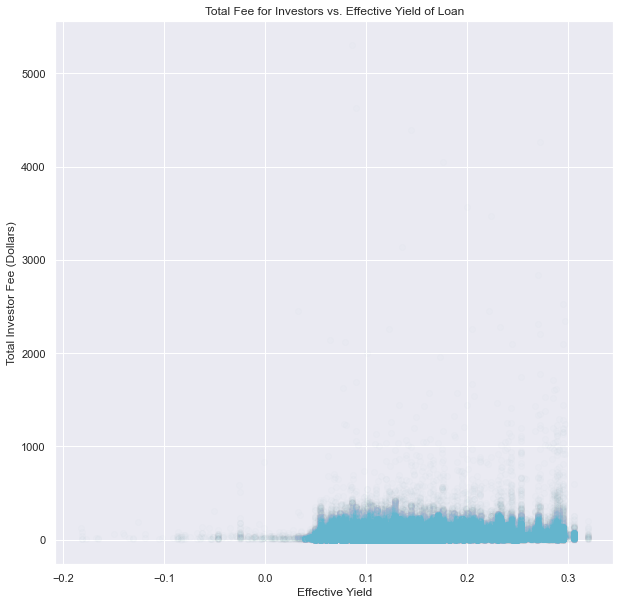

<Figure size 504x504 with 0 Axes>

In [73]:
plt.scatter(dataset['EstimatedEffectiveYield'], -1*total_fee_investors, color='c', alpha=0.01)
plt.title('Total Fee for Investors vs. Effective Yield of Loan')
plt.xlabel('Effective Yield')
plt.ylabel('Total Investor Fee (Dollars)')
plt.figure(figsize=(7,7))
plt.show()

Clearly there is no strong relationship or correlation so we will leave this for now. Although earlier it was seen that the distribution of the total investor fee was very well defined, it has very little to do with the effective yield!

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

*Summary of Observations*:

1. There is no apparent relationship between credit score and estimated effective yield.
2. There is no apparent relationship between Prosper Rating and estimated effective yield.
3. However, there are strong relationships between the *standard deviation of the effective yield* and both credit score and Prosper Rating. It was found that there is a strong negative correlation in both cases. 
4. Standard deviation of the effective yield is a measure of the spread of the effective yield for a given credit score or a given rating. It indicates the risk of the loan. In both cases, therefore, the strong negative correlations indicated that in general, higher credit scores and higher Prosper Ratings indicate *lower risk.*
5. Prosper Rating is not a good indicator of effective yield, but it is the better indicator of the *level of risk associated with a loan.* Compared to credit score, Prosper Rating has a much stronger *negative* correlation with the spread of effective yield (i.e. the risk of the loan).

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

*Summary of Observations*:

1. There is no apparent relationship between credit score and Prosper Rating. This was interesting and surprising, given that one would expect a professional loan rating to take into account the reliability of the borrower.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In the previous section it was found that only the standard deviation of the effective yield was closely related to Prosper Rating.

However, no other close relationships or strong correlations were found. Therefore the variables already studied (credit score, Prosper Rating, total investor fee) are now left to one side.

This next section examines how monthly loan repayment and the loan's original aount are related. It contains a multivariate analysis, where the effect of employment status of the borrower is also considered.

The relevant variables are:

1. Employment status of the borrower.
2. Monthly loan repayment.
3. The loan's original amount.

In [74]:
# Organising the relevant data
part_three = dataset[['EmploymentStatus', 'LoanOriginalAmount', 'MonthlyLoanPayment','EstimatedEffectiveYield']]

In [75]:
# Check
part_three.head()

,EmploymentStatus,LoanOriginalAmount,MonthlyLoanPayment,EstimatedEffectiveYield
0,Self-employed,9425,330.43,NaN
1,Employed,10000,318.93,0.07960
2,Not available,3001,123.32,NaN
3,Employed,10000,321.45,0.08490
4,Employed,15000,563.97,0.18316


In [76]:
# What forms of employment status are there?
part_three['EmploymentStatus'].value_counts()

Employed         67322
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

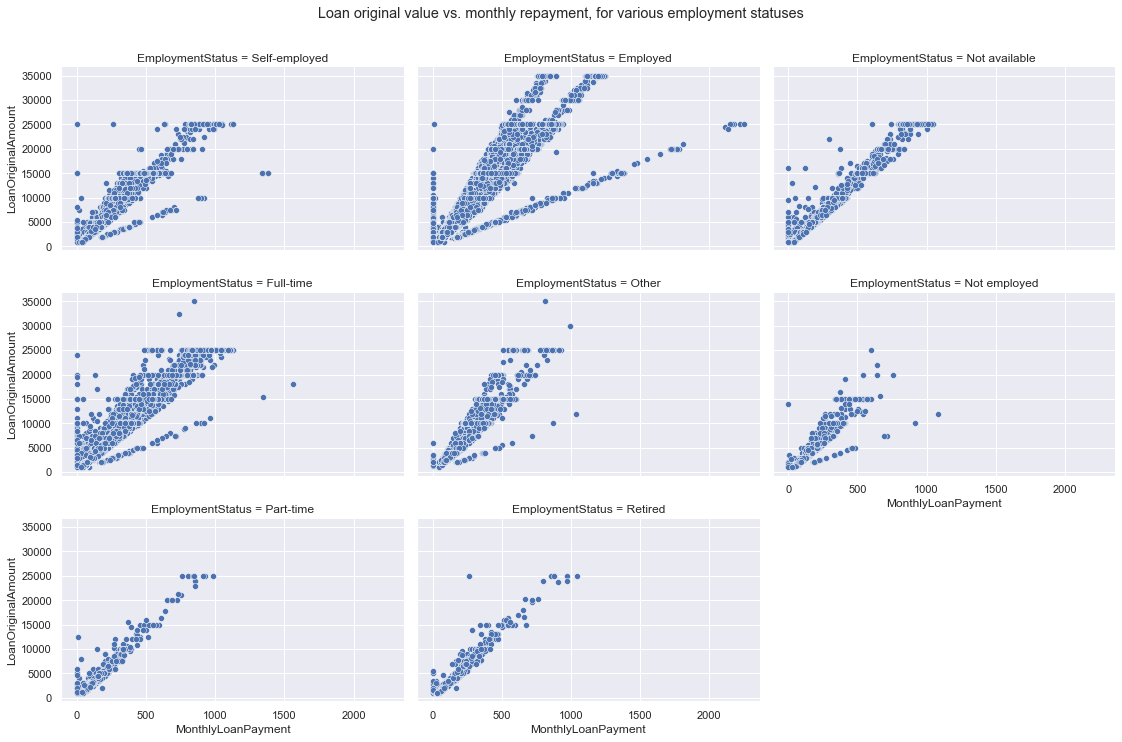

In [77]:
import seaborn as sb
from seaborn import FacetGrid

g = sb.FacetGrid(part_three, col='EmploymentStatus', col_wrap=3, height = 3.5, aspect=1.5, margin_titles = True)
g.map(sb.scatterplot, 'MonthlyLoanPayment', 'LoanOriginalAmount')
g.fig.suptitle('Loan original value vs. monthly repayment, for various employment statuses')
g.fig.subplots_adjust(top=0.9)
plt.show()

*Observations:*

Employment status *does* appear to have an effect on the relationship between monthly loan repayment and the original amount borrowed.

*Insights*:

1. The most consistent repayments are associated with retirement or part-time work. This is probably because those in these groups are least likely to borrow beyond their means.
2. For those in full-time work, or who are self-employed, there is a range of correlation. This is likely because the original amount borrowed and the amount repaid per month are highly dependent on the salary of the borrower. In the full-time employment group we expect the broadest range of salaries.

A further question is: **how does employment status affect the relationship between effective yield and original loan amount?**
Although from the scatter matrix earlier we saw that these appear to be unrelated, it may be that within certain subgroups they are related.

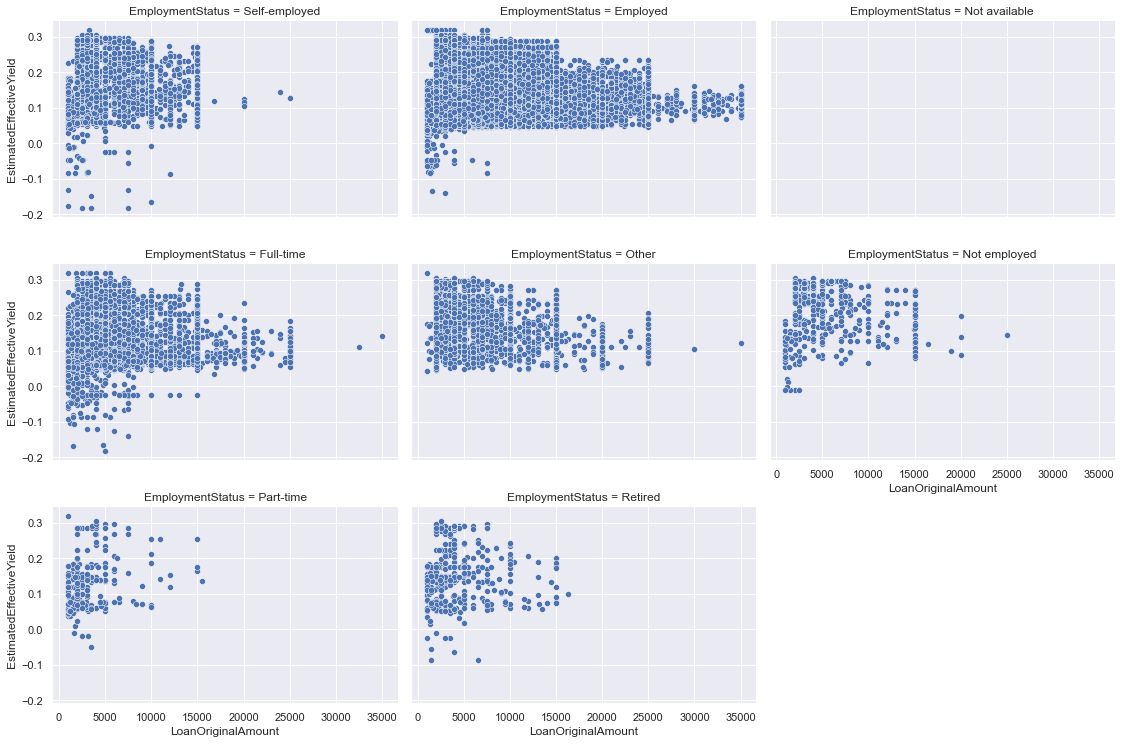

In [78]:
g = sb.FacetGrid(part_three, col='EmploymentStatus', col_wrap=3, height = 3.5, aspect=1.5, margin_titles = True)
g.map(sb.scatterplot, 'LoanOriginalAmount', 'EstimatedEffectiveYield')
plt.show()

We still find, however, that the original amount borrowed has very little to do with the effective yield. We also find that this holds true for any employment status. Notice that in the full-time and other categories, there is a very large range of loan amount borrowed. Nevertheless, there is still no real correlation observed.

### Summary of Observations

The only features whose relationship was strengthened were the monthly loan repayment and the loan's original value. They were strengthened with respect to each other, but there was still no observed effect on effective yield. 

### Surprising interactions between features?

The most surprising aspect of these investigations is that effective yield itself has little relationship to the variables investigated. It is the spread of the yield which is most strongly related to other variables. 

Even when broken down by subgroups, e.g. by employment status, this part of the investigation holds true!